XGBoost Code for running binary classificaiton of patient data

In [128]:
%cd ~/BadStomach

/home/jovyan/BadStomach


In [76]:
import xgboost as xgb
import pandas as pd
import numpy as np
import sklearn
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.datasets import dump_svmlight_file
from sklearn.externals import joblib
from sklearn.metrics import precision_score

In [131]:
datafile = open('testdata.txt', 'r')
data = pd.read_csv(datafile, sep = "\t")

In [143]:
for feature in data.columns: # Loop through all columns in the dataframe
    if data[feature].dtype == 'object': # Only apply for columns with categorical strings
        data[feature] = pd.Categorical(data[feature]).codes # Replace strings with an integer

In [145]:
X = data.drop("Season", axis=1)
y = data["Season"]

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [147]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [155]:
param = {'max_depth': 2, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'

In [149]:
bst = xgb.train(param, dtrain, num_round)
preds = bst.predict(dtest)

In [156]:
evallist = [(dtest, 'eval'), (dtrain, 'train')]

In [157]:
num_round = 10
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-auc:0.828555	train-auc:0.826164
[1]	eval-auc:0.985028	train-auc:0.985716
[2]	eval-auc:1	train-auc:1
[3]	eval-auc:1	train-auc:1
[4]	eval-auc:1	train-auc:1
[5]	eval-auc:1	train-auc:1
[6]	eval-auc:1	train-auc:1
[7]	eval-auc:1	train-auc:1
[8]	eval-auc:1	train-auc:1
[9]	eval-auc:1	train-auc:1


In [158]:
ypred = bst.predict(dtest)

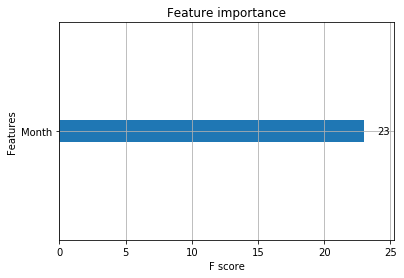

In [159]:
xgb.plot_importance(bst)